In [1]:
# !pip install ensemble_boxes

In [2]:
import pandas as pd
from ensemble_boxes import *
import numpy as np
from pycocotools.coco import COCO
import cv2
import matplotlib.pyplot as plt
import copy

In [3]:
# ensemble csv files
# submission lists
submission_files = ['../work_dirs/cascadeRCNN_r50_fpn/submission_best_bbox_mAP_50_epoch_23.csv',
                   '../work_dirs/sparse_rcnn_r50_fpn_300_proposals_crop_mstrain_704-1024_36_coco/submission_best_bbox_mAP_50_epoch_22.csv']
submission_df = [pd.read_csv(file) for file in submission_files]

In [4]:
image_ids = submission_df[0]['image_id'].tolist()

In [5]:
# ensemble 할 file의 image 정보를 불러오기 위한 json
annotation = '../dataset2/test.json'
coco = COCO(annotation)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
prediction_strings = []
file_names = []
# ensemble 시 설정할 iou threshold 
# 수정하면서 실습 하시면 됩니다!
iou_thr = 0.4

# 각 image id 별로 submission file에서 box좌표 추출
for i, image_id in enumerate(image_ids):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
# 각 submission file 별로 prediction box좌표 불러오기
    for df in submission_df:
        predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()
        
        if len(predict_list)==0 or len(predict_list)==1:
            continue
            
        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []
        
        for box in predict_list[:, 2:6].tolist():
            # bounding box 좌표값들이 0~1 사이의 값을 가져야 합니다.
            # Order: x1, y1, x2, y2
            box[0] = float(box[0]) / image_info['width']
            box[1] = float(box[1]) / image_info['height']
            box[2] = float(box[2]) / image_info['width']
            box[3] = float(box[3]) / image_info['height']
            box_list.append(box)
            
        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))
    
# 예측 box가 있다면 이를 ensemble 수행
# wbf 외에도 다른 ensemble을 사용할 수 있습니다
    if len(boxes_list):
        # boxes, scores, labels = nms(boxes_list, scores_list, labels_list, iou_thr=iou_thr)
        # boxes, scores, labels = soft_nms(boxes_list, scores_list, labels_list, iou_thr=iou_thr)
        # boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, iou_thr=iou_thr)
        boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, iou_thr=iou_thr)
        
        for box, score, label in zip(boxes, scores, labels):
            prediction_string += str(label) + ' ' + str(score) + ' ' + str(box[0] * image_info['width']) + ' ' + str(box[1] * image_info['height']) + ' ' + str(box[2] * image_info['width']) + ' ' + str(box[3] * image_info['height']) + ' '
    
    prediction_strings.append(prediction_string)
    file_names.append(image_id)

/opt/conda/envs/openmmlab/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/opt/conda/envs/openmmlab/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:64: UserWarning: X1 < 0 in box. Set it to 0.
  warnings.warn('X1 < 0 in box. Set it to 0.')
/opt/conda/envs/openmmlab/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/opt/conda/envs/openmmlab/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:76: UserWarning: Y1 < 0 in box. Set it to 0.
  warnings.warn('Y1 < 0 in box. Set it to 0.')
/opt/conda/envs/openmmlab/lib/python3.7/site-packages/ensemble_boxes/ensembl

In [7]:
submission = pd.DataFrame()
submission['image_id'] = file_names
submission['PredictionString'] = prediction_strings
submission.to_csv('../work_dirs/ensemble/submission_ensemble.csv')

submission.head()

,image_id,PredictionString
0,test/0000.jpg,7.0 0.47335157 559.72076 335.3286 712.5433 607...
1,test/0001.jpg,5.0 0.1710938662290573 143.10195922851562 9.75...
2,test/0002.jpg,1.0 0.28068920969963074 0.24365219473838806 22...
3,test/0003.jpg,0.0 0.18389375507831573 37.20196533203125 66.1...
4,test/0004.jpg,0.0 0.17446723580360413 424.5469665527344 503....


# Visualization

In [10]:
def get_box_label(df,idx,image_id):
    box_list = []
    label_list = []
    image_info = coco.loadImgs(idx)[0]
    
    predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
    predict_list = str(predict_string).split()
    
    if len(predict_list)==0 or len(predict_list)==1:
        return
        
    predict_list = np.reshape(predict_list, (-1, 6))
    
    
    for box in predict_list[:, 2:6].tolist():
        box[0] = float(box[0]) 
        box[1] = float(box[1]) 
        box[2] = float(box[2]) 
        box[3] = float(box[3]) 
        box_list.append(box)
        
    
    label_list = (list(map(int, map(float,predict_list[:, 0].tolist()))))
    return box_list, label_list

(-0.5, 1023.5, 1023.5, -0.5)

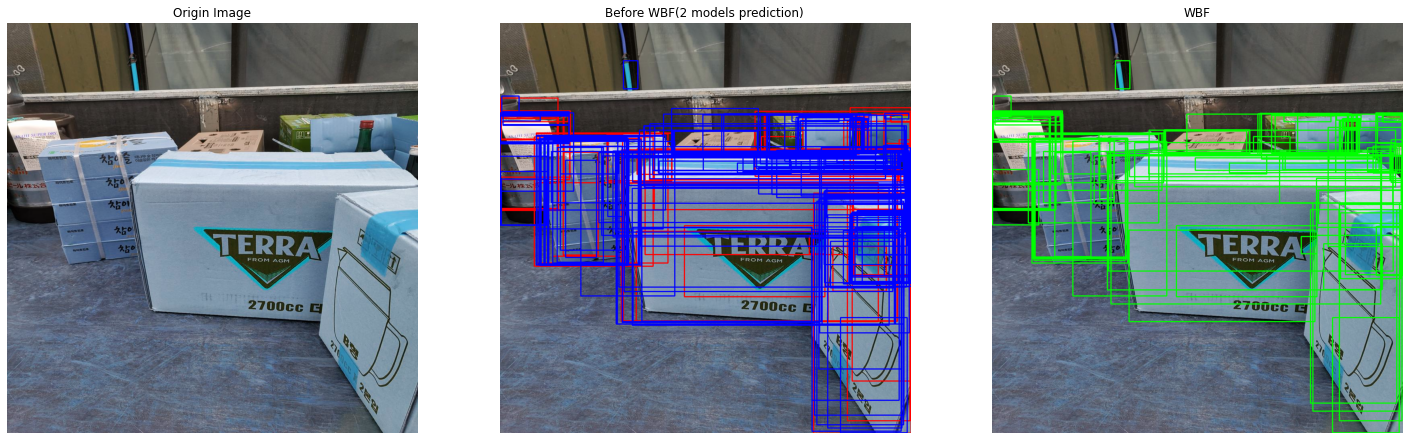

In [12]:
data_dir = '/opt/ml/level2-object-detection-level2-cv-14/dataset2/'

# id range 0 ~ 4870
img_idx = 2
img_id = coco.loadImgs(img_idx)[0]['file_name']
img_path=data_dir+ img_id
img = cv2.imread(img_path)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(25, 14)

# 최대 6개 모델을 앙상블 한다 가정하고 6 색상을 준비했습니다
# 모델을 더 추가해서 확인해 보고 싶으신 분들은 색상을 추가해주시면 됩니다!
color = [(255,0,0),(0,0,255),(255,255,0),(0,255,255),(255,0,255),(0,255,0)]

img_origin = img.copy()
img_wbf = img.copy()

for i,df in enumerate(submission_df):
    boxes, labels = get_box_label(df,img_idx,img_id)
    for box,label in zip(boxes,labels):
        x1,y1,x2,y2 = map(int,box)
        cv2.rectangle(img, (x1, y1), (x2, y2), color[i], 2)

boxes, labels = get_box_label(submission,img_idx,img_id)
for box,label in zip(boxes,labels):
    x1,y1,x2,y2 = map(int,box)
    cv2.rectangle(img_wbf, (x1, y1), (x2, y2), color[-1], 2)


axes[0].imshow(img_origin)
axes[0].set_title("Origin Image")
axes[0].axis('off')

axes[1].imshow(img)
axes[1].set_title(f"Before WBF({len(submission_df)} models prediction)")
axes[1].axis('off')

axes[2].imshow(img_wbf)
axes[2].set_title("WBF")
axes[2].axis('off')